In [1]:
import os
import sys
from importlib import reload
from pathlib import Path

import numpy as np
from torch.nn import ReLU, Linear
from torch_geometric.nn import GCNConv

In [2]:
# NOTE: Boilerplate setup for Jupyter imports

root = Path(os.getcwd()).parent
sys.path.append(
    (root / "src").as_posix()
)

import schema.configs as config_module
import enhancer as enhancer_module
import strategies as encoders_module
import schema.task as edges_module
import schema.data as data_module
import utils.metrics as utils_module

reload(edges_module)
reload(config_module)
reload(enhancer_module)
reload(encoders_module)
reload(data_module)
reload(utils_module)

PathConfig, TrainConfig, NetworkConfig = config_module.PathConfig, config_module.TrainConfig, config_module.NetworkConfig
Enhancer = enhancer_module.Enhancer
EnhancerData = data_module.EnhancerData
Task = edges_module.Task
euclid_metric, haversine_metric = utils_module.euclid_dist, utils_module.haversine_dist
TrainConfig = config_module.TrainConfig

Matplotlib is building the font cache; this may take a moment.


In [3]:
import pandas as pd

path_config = PathConfig(data_root="../data")
path_config.target_data = path_config.data_root / "processed/csv/melbourne.csv"

melbourne_df = pd.read_csv(path_config.target_data, header=None)

In [4]:
melbourne_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1480000.0,144.99840,-37.79960,-1.126001,-1.384247,-1.123999,-0.868172,-0.764542,-0.585494,-0.813574,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1035000.0,144.99340,-37.80790,-1.126001,-1.384247,-1.123999,-0.868172,-1.955939,-0.677778,-0.813574,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1465000.0,144.99440,-37.80930,0.005816,-1.384247,0.017537,0.750316,-1.955939,-0.721913,-0.813574,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,850000.0,144.99690,-37.79690,0.005816,-1.384247,0.017537,0.750316,-0.764542,-0.802159,-0.813574,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1600000.0,144.99410,-37.80720,1.137632,-1.384247,0.017537,-0.868172,0.426855,-0.749999,-0.813574,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19262,1101000.0,144.88516,-37.81095,0.005816,-0.758787,0.017537,-0.868172,0.426855,-0.412965,-0.152671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19263,1480000.0,144.88467,-37.81053,1.137632,-0.758787,1.159074,-0.868172,1.618252,0.198912,-0.152671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19264,888000.0,144.88826,-37.81551,-1.126001,-0.758787,-1.123999,0.750316,-0.764542,-0.794135,-0.152671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19265,705000.0,144.87856,-37.82286,-1.126001,-0.758787,-1.123999,-0.868172,0.426855,-0.549384,-0.152671,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
from torch import from_numpy
from torch_geometric.nn import SAGEConv
from utils.metrics import euclid_dist
from sklearn.metrics import mean_squared_error

melbourne_np = melbourne_df.to_numpy()
data = EnhancerData(
    features=from_numpy(melbourne_np[:, 3:]  .astype(np.float32)),
    target=from_numpy(melbourne_np[:, 0]   .astype(np.float32)),
    spatial=from_numpy(melbourne_np[:, 1:3] .astype(np.float32)),
)

In [6]:
train_config = TrainConfig()

gnn_setup = NetworkConfig(
    encoder=[
        (
            SAGEConv(data.features.shape[1], 256),
            "x, edge_index -> x",
        ),
        (
            SAGEConv(256, 256),
            "x, edge_index -> x",
        ),
    ],
    estimator=[
        Linear(256, 128),
        ReLU(),
        Linear(128, 128),
        ReLU(),
        Linear(128, 1),
    ]
)

In [7]:
knn_strategy = encoders_module.KNNStrategy(
    K=5,
    dist_metric=euclid_dist,
    cache_dir=path_config.edge_cache,
    cache_id="melbourne_knn",
)

threshold_strategy = encoders_module.ThresholdStrategy(
    dist_metric=haversine_metric,
    max_dist=5,
    cache_dir=path_config.edge_cache,
    cache_id="melbourne_threshold",
)

input_tasks = [
    Task(knn_strategy, data),
    Task(threshold_strategy, data),
]

## Comparison

In [10]:
import torch
from sklearn.model_selection import train_test_split

dataset = torch.hstack((data.features, data.spatial, data.target.reshape(-1, 1)))
train_dataset, test_dataset = train_test_split(dataset, train_size=0.8)

train_data = EnhancerData(
    features=train_dataset[:, :-3],
    spatial=train_dataset[:, -3:-1],
    target=train_dataset[:, -1],
)
test_data = EnhancerData(
    features=test_dataset[:, :-3],
    spatial=test_dataset[:, -3:-1],
    target=test_dataset[:, -1],
)

In [11]:
result = Enhancer.compare_strategies(
    train_data,
    test_data,
    gnn_setup,
    train_config,
    [knn_strategy, threshold_strategy],
)

GNN training: 100%|██████████| 10/10 [01:29<00:00,  8.93s/epoch, val_loss=2.79e+11]


In [12]:
import json

print(
    json.dumps(
        result.get_comparison([mean_squared_error]),
        indent="\t",
    )
)

{
	"melbourne_knn": {
		"mean_squared_error": 1093883549010.5073,
		"density": 0.00040146472193270066,
		"average degree": 6.187374294426783,
		"n connected components": 17,
		"largest component": 13082
	},
	"melbourne_threshold": {
		"mean_squared_error": 268427957081.49326,
		"density": 0.0802874102711384,
		"average degree": 1237.228992278243,
		"n connected components": 4,
		"largest component": 15217
	}
}


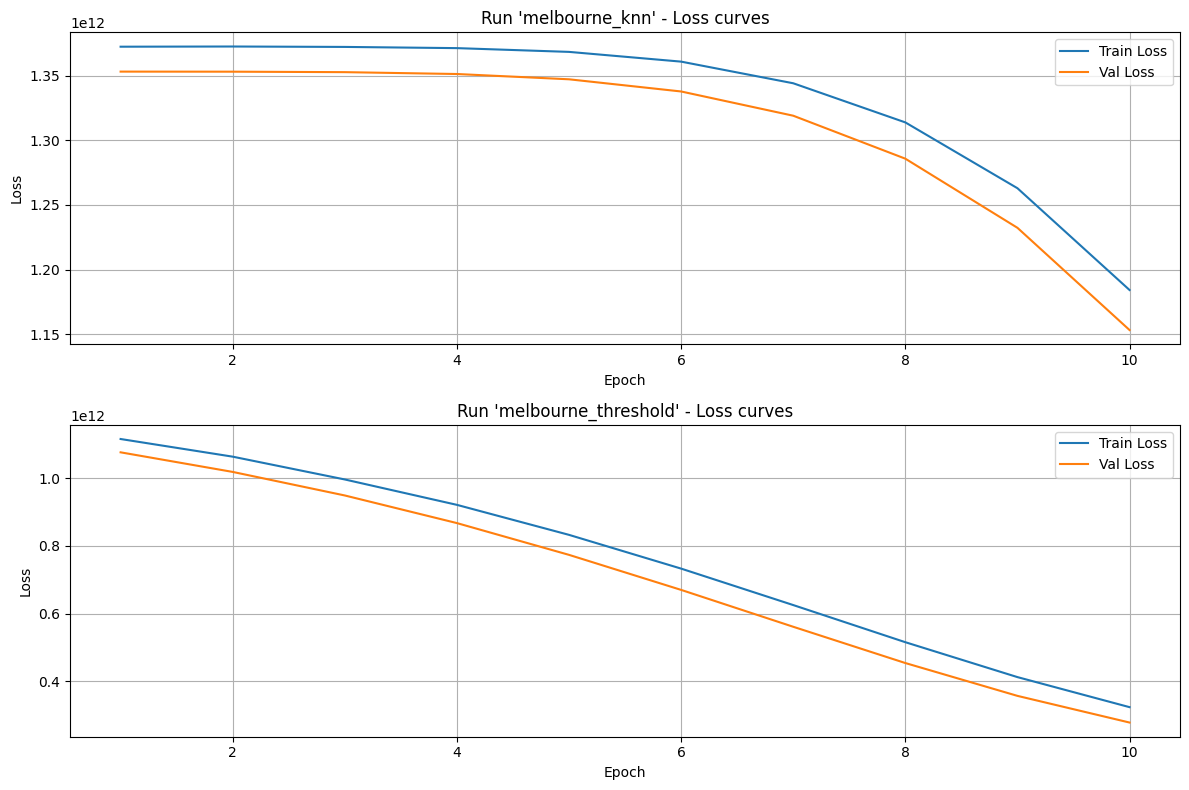

In [13]:
result.plot_train_logs()

## Processing

In [14]:
result = Enhancer.process_tasks(gnn_setup, train_config, input_tasks)

GNN training: 100%|██████████| 10/10 [00:16<00:00,  1.61s/epoch, val_loss=1.87e+11]


In [15]:
result._runs

[('melbourne_knn',
  tensor([1465000., 1876000.,  441000.,  ...,  765000.,  640000., 1480000.]),
  tensor([ 754904.7500, 1991541.6250,    6799.5635,  ...,  502769.4688,
          1535659.2500, 1123672.7500]),
  tensor([[   0,    0,    0,  ..., 3853, 3853, 3853],
          [1491, 1665, 1856,  ..., 2245, 2249, 3708]]),
  [(720861802543.3522, 665453592576.0),
   (656369871783.2411, 607637864448.0),
   (595154635980.4651, 555639570432.0),
   (544322253370.81635, 510104010752.0),
   (499642050892.7076, 470189539328.0),
   (461403614998.8206, 434186420224.0),
   (427421731739.81396, 402306564096.0),
   (399007507149.71185, 373983838208.0),
   (373516278419.7068, 348186935296.0),
   (348621933278.9162, 324399202304.0)]),
 ('melbourne_threshold',
  tensor([ 300000., 1350000., 1310000.,  ..., 1226000.,  650000., 1150000.]),
  tensor([ 793634.1250, 1711907.1250, 1319652.7500,  ..., 1075803.0000,
           822746.4375, 1163934.1250]),
  tensor([[   0,    0,    0,  ..., 3853, 3853, 3853],
       

In [16]:
print(result.get_comparison([mean_squared_error]))

{'melbourne_knn': {'mean_squared_error': 318624923014.92645, 'density': 0.0016024822986852993, 'average degree': 6.174364296834458, 'n connected components': 7, 'largest component': 3640}, 'melbourne_threshold': {'mean_squared_error': 196655440670.96832, 'density': 0.08133197014140983, 'average degree': 313.3720809548521, 'n connected components': 3, 'largest component': 3809}}


## Transformations

In [17]:
enhancer = Enhancer(
    gnn_setup, train_config, knn_strategy
)

In [18]:
gnn, _ = enhancer.fit(data)
transformed_data = enhancer.transform(data)

GNN training: 100%|██████████| 10/10 [00:04<00:00,  2.09epoch/s, val_loss=1.35e+11]


In [19]:
edge_index = knn_strategy(data.spatial)

In [20]:
gnn.predict(data.features, edge_index)

tensor([[1109647.7500],
        [1090966.1250],
        [1400364.2500],
        ...,
        [ 988109.1875],
        [ 801585.8750],
        [ 847649.4375]])

In [21]:
transformed_data.shape

(19267, 256)